# 2 PCF Clustering Demo

This notebook demonstrates how to visualize the two-point correlation function (2PCF) of spatial clustering using synthetic data. It includes examples of clustering with different spreads, and how to compute and plot the 2PCF and its components.
<br>

It also includes an interactive Plotly dashboard for exploring clustering parameters and their effects on the 2PCF.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import cmasher as cmr
import functions as fn
import plotting_scripts as ps


## Clustering plot example: matplotlib

In [2]:
# Parameters
n_points = 500
center = (0, 0)
clusters = [
    {'center': center, 'n_points': n_points, 'spread': 0.5},  # Tight
    {'center': center, 'n_points': n_points, 'spread': 1.5},  # Medium
    {'center': center, 'n_points': n_points, 'spread': 6}   # Very loose
]

bins = np.linspace(0, 2.0, 30)

# Generate clusters (same center, different spread)
points = [fn.generate_cluster(cl['center'], cl['n_points'], cl['spread'], seed=i)
          for i, cl in enumerate(clusters)]
spreads = [cl['spread'] for cl in clusters]  # for labeling

# Shared bounds for RR only
x_all = np.concatenate([x for x, y in points])
y_all = np.concatenate([y for x, y in points])
bounds = ((x_all.min(), x_all.max()), (y_all.min(), y_all.max()))


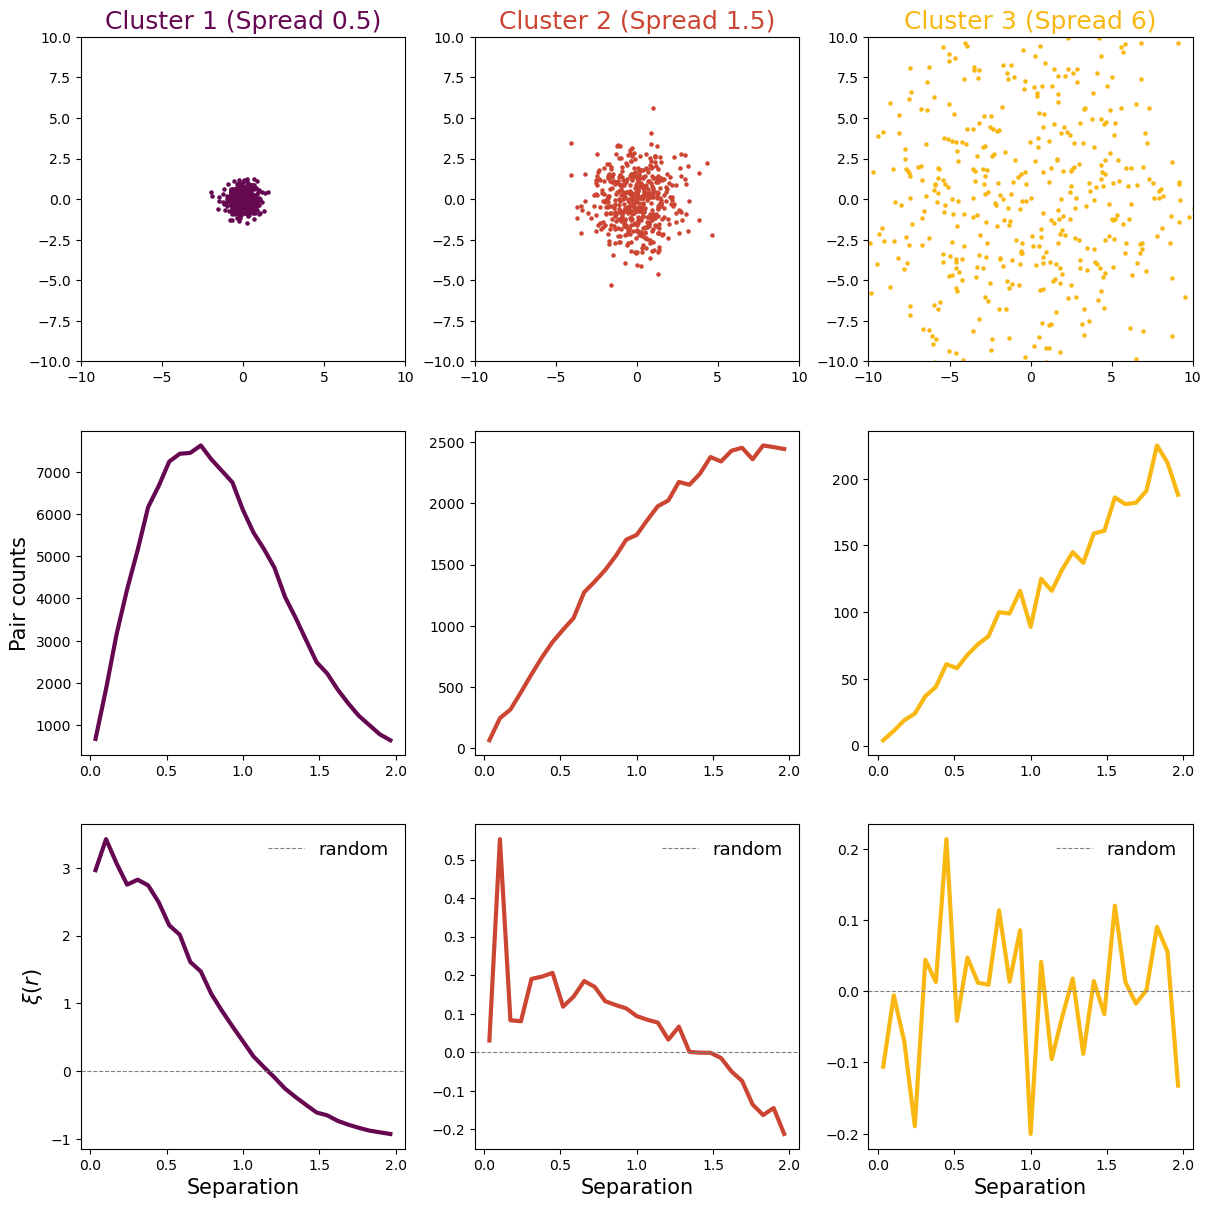

In [3]:
# Plot
xlim_fixed = (-10, 10)
ylim_fixed = (-10, 10)

# Colors from cmr.rainforest
colors = cmr.take_cmap_colors('cmr.pride_r', len(clusters), cmap_range=(0.1, 0.45), return_fmt='hex')
lw = 3
labelsize = 15

# Plot
fig, axs = plt.subplots(
    3, 3,
    figsize=(12, 12),
    constrained_layout=True,
    gridspec_kw={'wspace': 0.01, 'hspace': 0.01}  # smaller gaps between plots
)

for i, (x, y) in enumerate(points):
    r, dd, xi = fn.compute_2pcf_and_xi(x, y, bins, bounds=bounds, n_random=5000)
    color = colors[i]

    axs[0, i].scatter(x, y, s=5, color=color)
    axs[0, i].set_xlim(xlim_fixed)
    axs[0, i].set_ylim(ylim_fixed)
    axs[0, i].set_box_aspect(1)
    axs[0, i].set_title(f"Cluster {i+1} (Spread {spreads[i]})", color=color, fontsize=labelsize+3)

    axs[1, i].plot(r, dd, color=color, lw=lw)
    axs[1, i].set_ylabel("Pair counts", fontsize=labelsize)
    axs[1, i].set_box_aspect(1)

    axs[2, i].plot(r, xi, color=color, lw=lw)
    axs[2, i].axhline(0, color='gray', linestyle='--', linewidth=0.8, label="random")
    axs[2, i].set_ylabel(r"$\xi(r)$", fontsize=labelsize)
    axs[2, i].set_xlabel("Separation", fontsize=labelsize)
    axs[2, i].set_box_aspect(1)
    axs[2, i].legend(loc='upper right', fontsize=labelsize-2, frameon=False)

    if i > 0:
        axs[0, i].set_ylabel("")
        axs[1, i].set_ylabel("")
        axs[2, i].set_ylabel("")
plt.savefig(f"plots_output/2pcf_clusters.png", dpi=300, bbox_inches='tight')
plt.show()


## Clustering plot example: plotly


In [3]:
import numpy as np
import plotly.graph_objects as go
import cmasher as cmr
import panel as pn
import functions as fn  # my custom functions

pn.extension('plotly')

# Config
xlim_fixed = (-10, 10)
ylim_fixed = (-10, 10)
lw = 3
labelsize = 15
n_points = 500
center = (0, 0)

# Initial bounds
x, y = fn.generate_cluster(center, n_points, spread=1.0, seed=42)
bounds = ((x.min(), x.max()), (y.min(), y.max()))

# Updated discrete options
spread_values = [round(val, 1) for val in [0.1, 0.2, 0.5, 1.0, 1.5, 2.0, 5.0]]
max_sep_values = [int(val) for val in range(2, 11, 2)]
num_bins_values = [int(val) for val in range(10, 51, 5)]

# Discrete Sliders
spread_slider = pn.widgets.DiscreteSlider(name='Spread', options=spread_values, value=1.0)
max_sep_slider = pn.widgets.DiscreteSlider(name='Max Separation', options=max_sep_values, value=2)
num_bins_slider = pn.widgets.DiscreteSlider(name='Number of Bins', options=num_bins_values, value=20)

@pn.depends(spread=spread_slider, max_sep=max_sep_slider, num_bins=num_bins_slider)
def update_plot(spread, max_sep, num_bins):
    x, y = fn.generate_cluster(center, n_points, spread, seed=42)
    color = "#7ecaf6"
    bins = np.linspace(0, max_sep, num_bins)
    r, dd, xi = fn.compute_2pcf_and_xi(x, y, bins, bounds=bounds, n_random=5000)

    fig_cluster = go.Figure().add_trace(go.Scatter(
        x=x, y=y, mode='markers',
        marker=dict(size=10, color=color, line=dict(color='black', width=1)),
        name='Cluster'
    )).update_layout(
        title=f"Cluster (Spread {spread:.2f})",
        xaxis=dict(range=xlim_fixed, scaleanchor='y', scaleratio=1, title='X', showgrid=False),
        yaxis=dict(range=ylim_fixed, title='Y', showgrid=False),
        plot_bgcolor='white', paper_bgcolor='white', width=400, height=400,
        margin=dict(t=40, b=40, l=40, r=40)
    )

    fig_dd = go.Figure().add_trace(go.Scatter(
        x=r, y=dd, mode='lines+markers',
        line=dict(color=color, width=lw),
        marker=dict(size=10, color=color, line=dict(color='black', width=1)),
        name='Pair counts'
    )).update_layout(
        title="Pair Counts", xaxis_title="Separation", yaxis_title="Pair Counts",
        xaxis=dict(showgrid=False), yaxis=dict(showgrid=False),
        plot_bgcolor='white', paper_bgcolor='white', width=400, height=400,
        margin=dict(t=40, b=40, l=40, r=40)
    )

    fig_xi = go.Figure().add_trace(go.Scatter(
        x=r, y=xi, mode='lines+markers',
        line=dict(color=color, width=lw),
        marker=dict(size=10, color=color, line=dict(color='black', width=1)),
        name='ξ(r)'
    )).add_hline(y=0, line=dict(color='gray', dash='dash')).update_layout(
        title="Two-Point Correlation Function", xaxis_title="Separation", yaxis_title="ξ(r)",
        xaxis=dict(showgrid=False), yaxis=dict(showgrid=False),
        plot_bgcolor='white', paper_bgcolor='white', width=400, height=400,
        margin=dict(t=40, b=40, l=40, r=40), legend=dict(font=dict(size=labelsize-2))
    )

    return pn.Row(
        pn.pane.Plotly(fig_cluster, sizing_mode='stretch_width'),
        pn.pane.Plotly(fig_dd, sizing_mode='stretch_width'),
        pn.pane.Plotly(fig_xi, sizing_mode='stretch_width')
    )

# Sliders layout
sliders = pn.Column(spread_slider, max_sep_slider, num_bins_slider, pn.Spacer(height=20))
centered_sliders = pn.Row(pn.Spacer(width=100), sliders, pn.Spacer(width=100))

# Inject Google Fonts for Source Sans Pro
font_import = """
<link href="https://fonts.googleapis.com/css2?family=Source+Sans+Pro:wght@400;700&display=swap" rel="stylesheet">
<style>
body, h1, h2, h3, h4, h5, p, li {
    font-family: 'Source Sans Pro', sans-serif;
    color: #4a4a4a;
}
</style>
"""
font_import_pane = pn.pane.HTML(font_import, sizing_mode='stretch_width')

# Concise intro at the top
intro_html = """
<h2>Interactive 2PCF Clustering Demo</h2>
<p style="font-size: 10pt; line-height: 1.4;">
Explore how the spatial clustering of points (representing galaxies) depends on the spread parameter, affecting their "clumpiness." Adjust the sliders and observe changes in the plots below.
</p>
"""

# Detailed description below
detailed_html = """
<div style="max-width: 800px; margin: auto; padding: 20px; font-family: 'Source Sans Pro', sans-serif; font-size: 10pt; line-height: 1.6; color: #4a4a4a;">

  <h3 style="text-align: center;">Understanding Cosmic Structures Through Clustering</h3>

  <p>
    This visualization demonstrates a fundamental concept in cosmology: the <b>clustering of galaxies</b> in the Universe.
    The plot's left panel shows a slice of the cosmic web (mock) where points represent galaxies.
    The <b>spread</b> parameter controls how closely these galaxies clump together—small spreads mimic galaxy clusters, while larger spreads mimic a more uniform, random distribution.
  </p>

  <p style="font-size: 10pt; line-height: 1.4; font-family: 'Source Sans Pro', sans-serif;">
    In this example with 500 points, there are <b>124,750 unique pairs</b>, calculated using the formula <b><i>n</i>(<i>n</i>-1)/2</b> where <b><i>n</i>=500</b>.
    These pairs are distributed across distance bins to form the pair count histogram.
  </p>

    <p style="font-size: 10pt; line-height: 1.4; font-family: 'Source Sans Pro', sans-serif;">
    The bottom panel displays the <b>two-point correlation function <i>ξ(r)</i></b>.
    This shows how much more likely (or less likely) it is to find galaxy pairs at a given distance compared to a random distribution.
    A <b>positive <i>ξ(r)</i></b> means enhanced clustering at that scale, while a <b>negative <i>ξ(r)</i></b> indicates a tendency for galaxies to avoid that distance.
    The <b>dashed line at <i>ξ(r)</i> = 0</b> represents a completely random distribution with no clustering.
    </p>

  <p>
    With this tool, you can:
    <ul style="margin-left: 20px;">
      <li><b>Adjust the spread</b> to explore how clustering patterns change.</li>
      <li><b>Control the maximum separation</b> to observe clustering on different scales, from small groups to large cosmic structures.</li>
      <li><b>Change the number of bins</b> to fine-tune the resolution of clustering measurements.</li>
    </ul>
  </p>

  <p style="text-align: center; font-style: italic;">
    Try it out and observe how pair counts and <i>ξ(r)</i> reveal the cosmic web’s intricate structure!
  </p>

</div>
"""
intro_pane = pn.pane.HTML(intro_html, sizing_mode='stretch_width')
detailed_pane = pn.pane.HTML(detailed_html, sizing_mode='stretch_width')

# Final dashboard layout
dashboard = pn.Column(
    font_import_pane,  # Google Font import
    intro_pane,
    pn.Spacer(height=20),
    centered_sliders,
    pn.Spacer(height=40),
    update_plot,
    pn.Spacer(height=30),
    detailed_pane
)

# Save and serve
dashboard.save(
    "htmls/cluster_app.html",
    embed=True,
    embed_states={
        "spread": spread_values,
        "max_sep": max_sep_values,
        "num_bins": num_bins_values
    }
)

dashboard.save(
    "../docs/apps/cluster_app.html",
    embed=True,
    embed_states={
        "spread": spread_values,
        "max_sep": max_sep_values,
        "num_bins": num_bins_values
    }
)
dashboard.servable()


Column
    [0] HTML(str, sizing_mode='stretch_width')
    [1] HTML(str, sizing_mode='stretch_width')
    [2] Spacer(height=20)
    [3] Row
        [0] Spacer(width=100)
        [1] Column
            [0] DiscreteSlider(name='Spread', options=[0.1, 0.2, 0.5, ...], value=1.0)
            [1] DiscreteSlider(formatter='%d', name='Max Separation', options=[2, 4, 6, 8, 10], value=2)
            [2] DiscreteSlider(formatter='%d', name='Number of Bins', options=[10, 15, 20, 25, ...], value=20)
            [3] Spacer(height=20)
        [2] Spacer(width=100)
    [4] Spacer(height=40)
    [5] ParamFunction(function, _pane=Row, defer_load=False)
    [6] Spacer(height=30)
    [7] HTML(str, sizing_mode='stretch_width')

## Mock Cosmic Structures and 2PCF: matplotlib

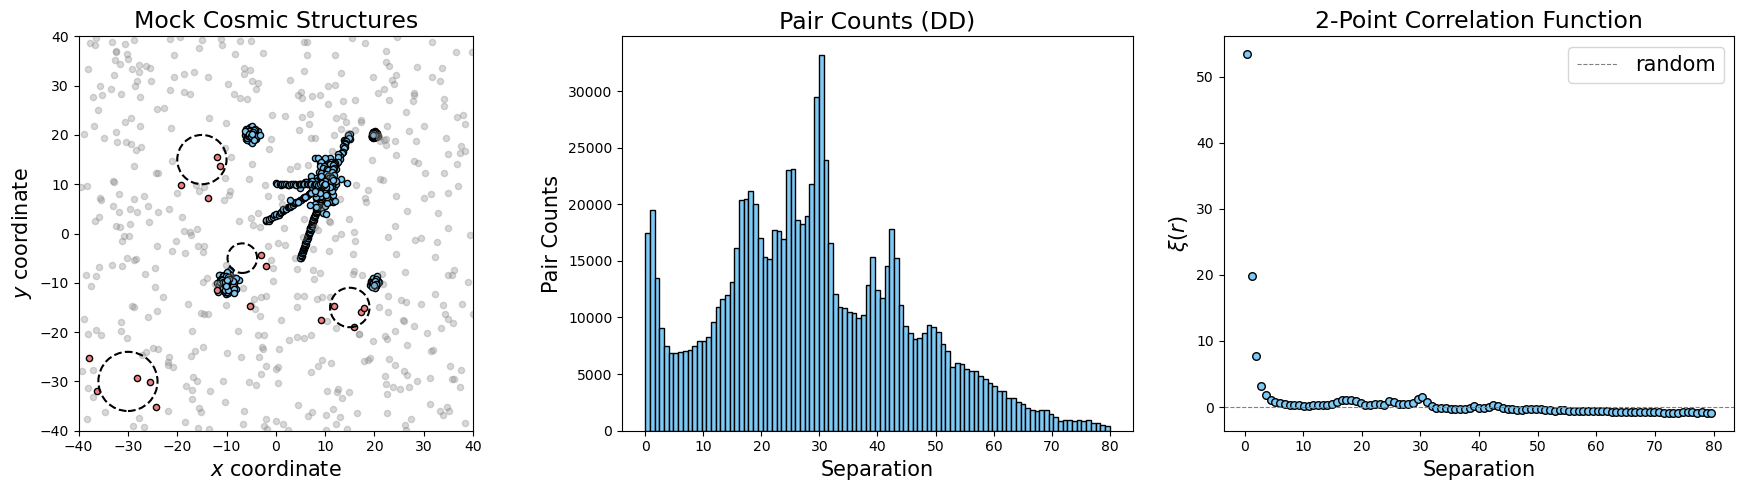

In [34]:
# --- Parameters ---
include_voids = True
n_background = 500
spread_ref = 1.5  # Reference spread (cluster 2 spread)

# Relative spread factors for clusters and filaments
spread_factors_clusters = [0.6, 1.0, 0.3, 0.4, 0.2]
spread_factors_filaments = [0.7, 0.2, 0.3, 0.4, 1.0, 0.2]

cluster_params = [
    {'center': (-10, -10), 'n_points': 200},
    {'center': (10, 10), 'n_points': 60},
    {'center': (20, -10), 'n_points': 80},
    {'center': (-5, 20), 'n_points': 150},
    {'center': (20, 20), 'n_points': 100}
]

filament_params = [
    {'start': (10, 15), 'end': (10, 10), 'n_points': 60, 'thickness': 1.5},
    {'start': (5, -5), 'end': (10, 10), 'n_points': 80, 'thickness': 0.4},
    {'start': (-2, 2.5), 'end': (10, 10), 'n_points': 50, 'thickness': 0.5},
    {'start': (15, 20), 'end': (10, 10), 'n_points': 40, 'thickness': 0.8},
    {'start': (7.5, 7.7), 'end': (10, 10), 'n_points': 50, 'thickness': 2.5},
    {'start': (0, 10), 'end': (10, 10), 'n_points': 30, 'thickness': 0.5}
]

# Define voids: list of (center, radius, n_points, spread)
voids_params = [
    {'center': (-6.8, -5), 'radius': 3, 'n_points': 4, 'spread': 5},
    {'center': (15, -15), 'radius': 4, 'n_points': 5, 'spread': 3},
    {'center': (-15, 15), 'radius': 5, 'n_points': 4, 'spread': 4},
    {'center': (-30, -30), 'radius': 6, 'n_points': 6, 'spread': 6}
]

xlim, ylim = (-40, 40), (-40, 40)

# --- Data Generation ---
clusters = [
    fn.generate_cluster(center=param['center'], n_points=param['n_points'], spread=spread_ref * factor)
    for param, factor in zip(cluster_params, spread_factors_clusters)
]
filaments = [
    fn.generate_filament(start=param['start'], end=param['end'], n_points=param['n_points'],
                         thickness=param['thickness'] * factor)
    for param, factor in zip(filament_params, spread_factors_filaments)
]

bg = fn.generate_random_background(n_background, xlim=xlim, ylim=ylim)

# Handle voids inclusion
voids = []
if include_voids:
    for vp in voids_params:
        void = fn.generate_cluster(center=vp['center'], n_points=vp['n_points'], spread=vp['spread'])
        voids.append(void)
        bg = fn.mask_void_region(*bg, center=vp['center'], radius=vp['radius'])  # Mask background inside each void

# --- Data Aggregation ---
x_all_components = [c[0] for c in clusters] + [f[0] for f in filaments] + [bg[0]]
y_all_components = [c[1] for c in clusters] + [f[1] for f in filaments] + [bg[1]]
if include_voids:
    x_all_components.extend([v[0] for v in voids])
    y_all_components.extend([v[1] for v in voids])

x_all_mock = np.concatenate(x_all_components)
y_all_mock = np.concatenate(y_all_components)

# --- 2PCF Computation ---
bins = np.linspace(0, 80, 100)
r, dd_hist, xi = fn.compute_2pcf_and_xi(x_all_mock, y_all_mock, bins=bins, n_random=5000, bounds=(xlim, ylim))

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fontsize, markersize, color = 15, 20, "#7ecaf6"

# Panel 1: Mock Universe
ax1 = axes[0]
for cluster in clusters:
    ax1.scatter(*cluster, s=markersize, color=color, ec='k')
for filament in filaments:
    ax1.scatter(*filament, s=markersize, color=color, ec='k')
ax1.scatter(*bg, s=markersize, color='gray', alpha=0.3)

if include_voids:
    color_voids = 'lightcoral'
    for void, vp in zip(voids, voids_params):
        ax1.scatter(*void, s=markersize, color=color_voids, edgecolor='black', label=f"Void at {vp['center']}")
        void_circle = Circle(vp['center'], vp['radius'], edgecolor='black', facecolor='none', linestyle='--', linewidth=1.5)
        ax1.add_patch(void_circle)

ax1.set_aspect('equal')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_xlabel("$x$ coordinate", fontsize=fontsize)
ax1.set_ylabel("$y$ coordinate", fontsize=fontsize)
ax1.set_title(f"Mock Cosmic Structures", fontsize=fontsize+2)
#if include_voids:
    #ax1.legend(fontsize=fontsize-2)

# Panel 2: Pair Counts (DD)
ax2 = axes[1]
ax2.bar(r, dd_hist, width=np.diff(bins), align='center', color=color, alpha=1, ec='k')
ax2.set_xlabel("Separation", fontsize=fontsize)
ax2.set_ylabel("Pair Counts", fontsize=fontsize)
ax2.set_title("Pair Counts (DD)", fontsize=fontsize+2)

# Panel 3: 2PCF ξ(r)
ax3 = axes[2]
ax3.axhline(0, color='gray', linestyle='--', linewidth=0.8, label="random")
ax3.scatter(r, xi, color=color, ec="k", s=markersize+10)
ax3.set_xlabel("Separation", fontsize=fontsize)
ax3.set_ylabel(r"$\xi(r)$", fontsize=fontsize)
ax3.set_title("2-Point Correlation Function", fontsize=fontsize+2)
ax3.legend(fontsize=fontsize)

plt.tight_layout()

# Generate filename dynamically based on include_voids
suffix = '_with_voids' if include_voids else '_no_voids'
filename = f"plots_output/mock_cosmic_structures_refspread{suffix}.png"

plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


## Mock Cosmic Structures and 2PCF with Shear: plotly

In [49]:
import numpy as np
import plotly.graph_objects as go
import panel as pn
import functions as fn

pn.extension('plotly')

# --- Parameters ---
spread_options = [0.1, 0.2, 0.5, 1.0, 2.0, 4.0]
include_voids_toggle = pn.widgets.Checkbox(name='Include Voids', value=False)
spread_selector = pn.widgets.DiscreteSlider(name='Reference Spread', options=spread_options, value=1.0)

n_background = 500
xlim, ylim = (-40, 40), (-40, 40)

cluster_params = [
    {'center': (-10, -10), 'n_points': 200},
    {'center': (10, 10), 'n_points': 60},
    {'center': (20, -10), 'n_points': 80},
    {'center': (-5, 20), 'n_points': 150},
    {'center': (20, 20), 'n_points': 100}
]
spread_factors_clusters = [0.6, 1.0, 0.3, 0.4, 0.2]
filament_params = [
    {'start': (10, 15), 'end': (10, 10), 'n_points': 60, 'thickness': 1.5},
    {'start': (5, -5), 'end': (10, 10), 'n_points': 80, 'thickness': 0.4},
    {'start': (-2, 2.5), 'end': (10, 10), 'n_points': 50, 'thickness': 0.5},
    {'start': (15, 20), 'end': (10, 10), 'n_points': 40, 'thickness': 0.8},
    {'start': (7.5, 7.7), 'end': (10, 10), 'n_points': 50, 'thickness': 2.5},
    {'start': (0, 10), 'end': (10, 10), 'n_points': 30, 'thickness': 0.5}
]
spread_factors_filaments = [0.7, 0.2, 0.3, 0.4, 1.0, 0.2]

# Void definitions (without n_points yet)
base_voids = [
    {'center': (-6.8, -5), 'radius': 3, 'spread': 5},
    {'center': (15, -15), 'radius': 4, 'spread': 3},
    {'center': (-15, 15), 'radius': 5, 'spread': 4},
    {'center': (-30, -30), 'radius': 6, 'spread': 6}
]
void_density_fraction = 0.01  # Voids have 1% of background density

@pn.depends(spread_selector, include_voids_toggle)
def generate_dashboard(spread, include_voids):
    clusters = [fn.generate_cluster(p['center'], p['n_points'], spread * f) for p, f in zip(cluster_params, spread_factors_clusters)]
    filaments = [fn.generate_filament(p['start'], p['end'], p['n_points'], thickness=p['thickness'] * f) for p, f in zip(filament_params, spread_factors_filaments)]
    bg = fn.generate_random_background(n_background, xlim, ylim)

    voids = []
    if include_voids:
        total_area = (xlim[1] - xlim[0]) * (ylim[1] - ylim[0])
        bg_density = n_background / total_area
        for v in base_voids:
            void_area = np.pi * (v['radius'] ** 2)
            n_points_void = max(int(bg_density * void_area * void_density_fraction), 1)
            void = fn.generate_cluster(v['center'], n_points_void, v['spread'])
            voids.append(void)
            bg = fn.mask_void_region(*bg, center=v['center'], radius=v['radius'])

    x_all = np.concatenate([c[0] for c in clusters] + [f[0] for f in filaments] + [bg[0]] + ([v[0] for v in voids] if include_voids else []))
    y_all = np.concatenate([c[1] for c in clusters] + [f[1] for f in filaments] + [bg[1]] + ([v[1] for v in voids] if include_voids else []))
    bins = np.linspace(0, 80, 100)
    r, dd, xi = fn.compute_2pcf_and_xi(x_all, y_all, bins=bins, n_random=5000, bounds=(xlim, ylim))

    plot_bg = 'rgba(255,255,255,0)'
    paper_bg = 'rgba(255,255,255,0)'
    plot_size = 350
    color_clusters = "#7ecaf6"
    color_voids = 'lightcoral'

    # Structures plot
    fig_structures = go.Figure()
    for c in clusters:
        fig_structures.add_trace(go.Scatter(x=c[0], y=c[1], mode='markers',
                                            marker=dict(size=8, color=color_clusters, line=dict(color='black', width=1)),
                                            showlegend=False))
    for f in filaments:
        fig_structures.add_trace(go.Scatter(x=f[0], y=f[1], mode='markers',
                                            marker=dict(size=6, color=color_clusters, line=dict(color='black', width=1)),
                                            showlegend=False))
    fig_structures.add_trace(go.Scatter(x=bg[0], y=bg[1], mode='markers',
                                        marker=dict(size=3, color='gray', opacity=0.3),
                                        showlegend=False))
    if include_voids:
        for v in voids:
            fig_structures.add_trace(go.Scatter(x=v[0], y=v[1], mode='markers',
                                                marker=dict(size=8, color=color_voids, line=dict(color='black', width=1)),
                                                showlegend=False))
    fig_structures.update_layout(title=f"Mock Cosmic Structures",
                                 xaxis=dict(range=xlim, scaleanchor='y', scaleratio=1, title='X'),
                                 yaxis=dict(range=ylim, title='Y'),
                                 width=plot_size, height=plot_size,
                                 plot_bgcolor=plot_bg, paper_bgcolor=paper_bg,
                                 margin=dict(l=10, r=10, t=40, b=10))

    # Pair Counts Histogram
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_widths = bins[1:] - bins[:-1]
    fig_dd = go.Figure(go.Bar(
        x=bin_centers, y=dd, width=bin_widths,
        marker=dict(color=color_clusters, line=dict(color='black', width=1))
    ))
    fig_dd.update_layout(title="Pair Counts Histogram", xaxis_title="Separation", yaxis_title="Pair Counts",
                         width=plot_size, height=plot_size,
                         plot_bgcolor=plot_bg, paper_bgcolor=paper_bg,
                         margin=dict(l=10, r=10, t=40, b=10))

    # 2PCF ξ(r)
    fig_xi = go.Figure(go.Scatter(
        x=r, y=xi, mode='lines+markers',
        line=dict(color=color_clusters, width=2),
        marker=dict(size=8, color=color_clusters, line=dict(color='black', width=1)),
        name='ξ(r)'
    ))
    fig_xi.add_hline(y=0, line=dict(color='gray', dash='dash'))
    fig_xi.update_layout(title="Two-Point Correlation Function", xaxis_title="Separation", yaxis_title="ξ(r)",
                         width=plot_size, height=plot_size,
                         plot_bgcolor=plot_bg, paper_bgcolor=paper_bg,
                         margin=dict(l=10, r=10, t=40, b=10))

    return pn.Row(
        pn.pane.Plotly(fig_structures, sizing_mode='fixed', width=plot_size, height=plot_size),
        pn.pane.Plotly(fig_dd, sizing_mode='fixed', width=plot_size, height=plot_size),
        pn.pane.Plotly(fig_xi, sizing_mode='fixed', width=plot_size, height=plot_size)
    )

# Layout and Dashboard
intro_pane = pn.pane.Markdown("""
# Interactive Mock Cosmic Structures Demo
Adjust the reference spread and toggle voids to explore clustering patterns and the two-point correlation function.
""", sizing_mode='stretch_width')
sliders_pane = pn.Row(spread_selector, include_voids_toggle)

dashboard = pn.Column(intro_pane, sliders_pane, generate_dashboard)
dashboard.save("htmls/mock_cosmic_structures_app.html", embed=True)
dashboard.save("../docs/apps/mock_cosmic_structures_app.html", embed=True)
dashboard.servable()


Column
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] Row
        [0] DiscreteSlider(name='Reference Spread', options=[0.1, 0.2, 0.5, ...], value=1.0)
        [1] Checkbox(name='Include Voids')
    [2] ParamFunction(function, _pane=Row, defer_load=False)

In [50]:
dashboard.show()  # To display the dashboard in a Jupyter notebook or panel server

Launching server at http://localhost:49860


In [45]:
import numpy as np
import plotly.graph_objects as go
import panel as pn
import functions as fn

pn.extension('plotly')

# --- Parameters ---
spread_options = [0.2, 0.5, 1.0, 2.0]
include_voids_toggle = pn.widgets.Checkbox(name='Include Voids', value=False)
spread_selector = pn.widgets.DiscreteSlider(name='Reference Spread', options=spread_options, value=1.0)

n_background = 500
cluster_params = [
    {'center': (-10, -10), 'n_points': 200},
    {'center': (10, 10), 'n_points': 60},
    {'center': (20, -10), 'n_points': 80},
    {'center': (-5, 20), 'n_points': 150},
    {'center': (20, 20), 'n_points': 100}
]
spread_factors_clusters = [0.6, 1.0, 0.3, 0.4, 0.2]
filament_params = [
    {'start': (10, 15), 'end': (10, 10), 'n_points': 60, 'thickness': 1.5},
    {'start': (5, -5), 'end': (10, 10), 'n_points': 80, 'thickness': 0.4},
    {'start': (-2, 2.5), 'end': (10, 10), 'n_points': 50, 'thickness': 0.5},
    {'start': (15, 20), 'end': (10, 10), 'n_points': 40, 'thickness': 0.8},
    {'start': (7.5, 7.7), 'end': (10, 10), 'n_points': 50, 'thickness': 2.5},
    {'start': (0, 10), 'end': (10, 10), 'n_points': 30, 'thickness': 0.5}
]
spread_factors_filaments = [0.7, 0.2, 0.3, 0.4, 1.0, 0.2]
voids_params = [
    {'center': (-6.8, -5), 'radius': 3, 'n_points': 4, 'spread': 5},
    {'center': (15, -15), 'radius': 4, 'n_points': 5, 'spread': 3},
    {'center': (-15, 15), 'radius': 5, 'n_points': 4, 'spread': 4},
    {'center': (-30, -30), 'radius': 6, 'n_points': 6, 'spread': 6}
]
xlim, ylim = (-40, 40), (-40, 40)

@pn.depends(spread_selector, include_voids_toggle)
def generate_dashboard(spread, include_voids):
    clusters = [fn.generate_cluster(p['center'], p['n_points'], spread * f) for p, f in zip(cluster_params, spread_factors_clusters)]
    filaments = [fn.generate_filament(p['start'], p['end'], p['n_points'], thickness=p['thickness'] * f) for p, f in zip(filament_params, spread_factors_filaments)]
    bg = fn.generate_random_background(n_background, xlim, ylim)
    voids = []
    if include_voids:
        for v in voids_params:
            void = fn.generate_cluster(v['center'], v['n_points'], v['spread'])
            voids.append(void)
            bg = fn.mask_void_region(*bg, center=v['center'], radius=v['radius'])

    x_all = np.concatenate([c[0] for c in clusters] + [f[0] for f in filaments] + [bg[0]] + ([v[0] for v in voids] if include_voids else []))
    y_all = np.concatenate([c[1] for c in clusters] + [f[1] for f in filaments] + [bg[1]] + ([v[1] for v in voids] if include_voids else []))
    bins = np.linspace(0, 80, 100)
    r, dd, xi = fn.compute_2pcf_and_xi(x_all, y_all, bins=bins, n_random=5000, bounds=(xlim, ylim))

    # Styling settings
    plot_bg = 'rgba(255,255,255,0)'
    paper_bg = 'rgba(255,255,255,0)'
    plot_size = 350
    color_clusters = "#7ecaf6"
    color_voids = 'lightcoral'

    # Panel 1: Mock Cosmic Structures
    fig_structures = go.Figure()
    for c in clusters:
        fig_structures.add_trace(go.Scatter(x=c[0], y=c[1], mode='markers',
                                            marker=dict(size=8, color=color_clusters, line=dict(color='black', width=1)),
                                            showlegend=False))
    for f in filaments:
        fig_structures.add_trace(go.Scatter(x=f[0], y=f[1], mode='markers',
                                            marker=dict(size=6, color=color_clusters, line=dict(color='black', width=1)),
                                            showlegend=False))
    fig_structures.add_trace(go.Scatter(x=bg[0], y=bg[1], mode='markers',
                                        marker=dict(size=3, color='gray', opacity=0.3),
                                        showlegend=False))
    if include_voids:
        for v in voids:
            fig_structures.add_trace(go.Scatter(x=v[0], y=v[1], mode='markers',
                                                marker=dict(size=8, color=color_voids, line=dict(color='black', width=1)),
                                                showlegend=False))
    fig_structures.update_layout(
        title=f"Mock Cosmic Structures (Spread={spread}, Voids={'Yes' if include_voids else 'No'})",
        xaxis=dict(range=xlim, scaleanchor='y', scaleratio=1, title='X'),
        yaxis=dict(range=ylim, title='Y'),
        width=plot_size, height=plot_size,
        plot_bgcolor=plot_bg, paper_bgcolor=paper_bg,
        margin=dict(l=10, r=10, t=40, b=10)
    )

    # Panel 2: Pair Counts Histogram
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_widths = bins[1:] - bins[:-1]
    fig_dd = go.Figure(go.Bar(
        x=bin_centers, y=dd, width=bin_widths,
        marker=dict(color=color_clusters, line=dict(color='black', width=1))
    ))
    fig_dd.update_layout(
        title="Pair Counts Histogram", xaxis_title="Separation", yaxis_title="Pair Counts",
        width=plot_size, height=plot_size,
        plot_bgcolor=plot_bg, paper_bgcolor=paper_bg,
        margin=dict(l=10, r=10, t=40, b=10)
    )

    # Panel 3: 2PCF ξ(r)
    fig_xi = go.Figure(go.Scatter(
        x=r, y=xi, mode='lines+markers',
        line=dict(color=color_clusters, width=2),
        marker=dict(size=8, color=color_clusters, line=dict(color='black', width=1)),
        name='ξ(r)'
    ))
    fig_xi.add_hline(y=0, line=dict(color='gray', dash='dash'))
    fig_xi.update_layout(
        title="Two-Point Correlation Function", xaxis_title="Separation", yaxis_title="ξ(r)",
        width=plot_size, height=plot_size,
        plot_bgcolor=plot_bg, paper_bgcolor=paper_bg,
        margin=dict(l=10, r=10, t=40, b=10)
    )
    plotly_width = 350
    plotly_height = 350

    return pn.Row(
        pn.pane.Plotly(fig_structures, sizing_mode='fixed', width=plotly_width, height=plotly_height),
        pn.pane.Plotly(fig_dd, sizing_mode='fixed', width=plotly_width, height=plotly_height),
        pn.pane.Plotly(fig_xi, sizing_mode='fixed', width=plotly_width, height=plotly_height)
    )

# Layout and Dashboard
intro_pane = pn.pane.Markdown("""
# Interactive Mock Cosmic Structures Demo
Adjust the reference spread and toggle voids to explore clustering patterns and the two-point correlation function.
""", sizing_mode='stretch_width')
sliders_pane = pn.Row(spread_selector, include_voids_toggle)

dashboard = pn.Column(intro_pane, sliders_pane, generate_dashboard)
dashboard.save("htmls/mock_cosmic_structures_app.html", embed=True)
dashboard.save("../docs/apps/mock_cosmic_structures_app.html", embed=True)
dashboard.servable()


Column
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] Row
        [0] DiscreteSlider(name='Reference Spread', options=[0.2, 0.5, 1.0, 2.0], value=1.0)
        [1] Checkbox(name='Include Voids')
    [2] ParamFunction(function, _pane=Row, defer_load=False)

In [47]:
dashboard.show()  # To

Launching server at http://localhost:49833


2025-05-26 11:08:39,462 ERROR: panel.reactive - Callback failed for object named 'Include Voids' changing property {'value': True} 
Traceback (most recent call last):
  File "/Users/niko/anaconda3/envs/ccl3/lib/python3.12/site-packages/panel/reactive.py", line 470, in _process_events
    self.param.update(**self_params)
  File "/Users/niko/anaconda3/envs/ccl3/lib/python3.12/site-packages/param/parameterized.py", line 2406, in update
    restore = dict(self_._update(arg, **kwargs))
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/niko/anaconda3/envs/ccl3/lib/python3.12/site-packages/param/parameterized.py", line 2439, in _update
    self_._batch_call_watchers()
  File "/Users/niko/anaconda3/envs/ccl3/lib/python3.12/site-packages/param/parameterized.py", line 2624, in _batch_call_watchers
    self_._execute_watcher(watcher, events)
  File "/Users/niko/anaconda3/envs/ccl3/lib/python3.12/site-packages/param/parameterized.py", line 2586, in _execute_watcher
    watcher.fn(*arg

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x110885b20>>, <Task finished name='Task-1694' coro=<ServerSession.with_document_locked() done, defined at /Users/niko/anaconda3/envs/ccl3/lib/python3.12/site-packages/bokeh/server/session.py:77> exception=RuntimeError("Models must be owned by only a single document, ImportedStyleSheet(id='cd463787-d60b-4e51-970a-bf6250c841b1', ...) is already in a doc")>)
Traceback (most recent call last):
  File "/Users/niko/anaconda3/envs/ccl3/lib/python3.12/site-packages/tornado/ioloop.py", line 750, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/Users/niko/anaconda3/envs/ccl3/lib/python3.12/site-packages/tornado/ioloop.py", line 774, in _discard_future_result
    future.result()
  File "/Users/niko/anaconda3/envs/ccl3/lib/python3.12/site-packages/bokeh/server/session.py", line 98, in _needs_document_lock_wrapper
  